In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import Normalize
from PIL import Image


from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

In [2]:
chip=CHIP(PS(host="192.168.1.10", port = 7, debug=0),init=True)
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 55078


In [3]:
state_num = 16

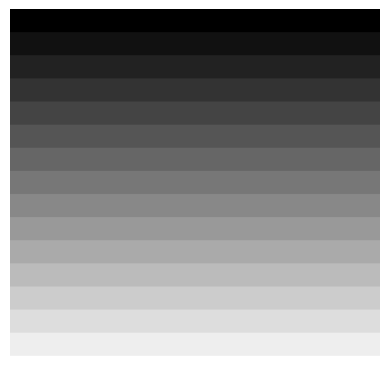

In [4]:
img = np.zeros((256,256))
for i in range(state_num):
    interval = int(256/state_num)
    img[i*interval:(i+1)*interval,:]=i

# row,col = img.shape
# for i in range(row):
#     for j in range(col):
#         print(img[i,j],end=' ')
#     print('')

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# 设置电导映射的上下界

200.0 250.0
950.0
1000.0


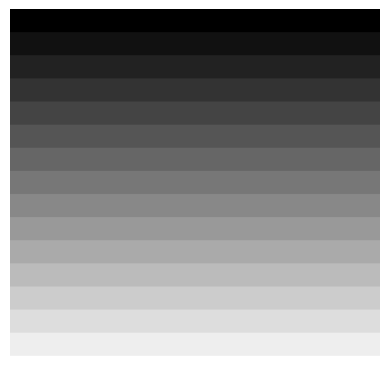

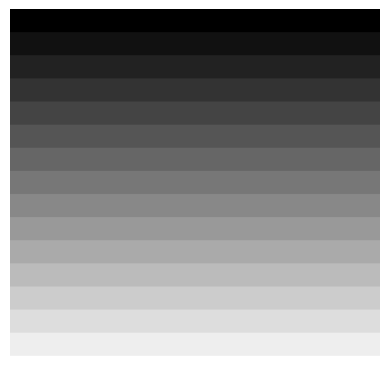

In [5]:
mincond,maxcond = 200,1000
img_cond_lower = img*(maxcond-mincond)/state_num+mincond
img_cond_upper = (img+1)*(maxcond-mincond)/state_num+mincond
print(img_cond_lower[1,1],img_cond_upper[1,1])
print(img_cond_lower[255,1])
print(img_cond_upper[255,1])

plt.imshow(img_cond_lower, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(img_cond_upper, cmap='gray')
plt.axis('off')
plt.show()

# 设置tg电压映射

In [6]:
min_tg,max_tg = 1.2,2
tg_v = img*(max_tg-min_tg)/(state_num-1)+min_tg

print(tg_v[0,1],tg_v[255,1])


1.2 2.0


# 1. 初始读阵列

In [15]:
# 这里用逐点读+减去0v读的base
voltage_base1 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
voltage1 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)

需要读65536个点
需要读65536个点


In [ ]:
cmap = plt.cm.viridis
norm = Normalize(vmin=200, vmax=1000)
im = plt.imshow(chip.voltage_to_cond(voltage1-voltage_base1), cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

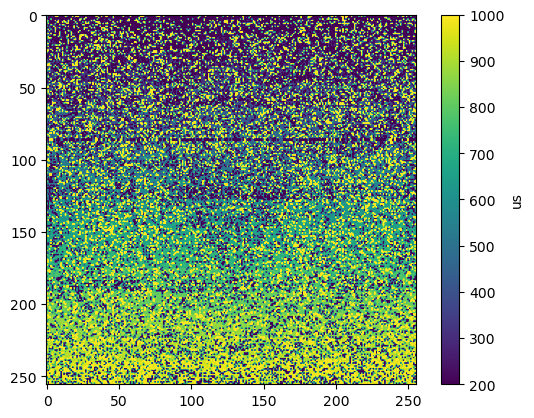

In [16]:
cmap = plt.cm.viridis
norm = Normalize(vmin=200, vmax=1000)
im = plt.imshow(chip.voltage_to_cond(voltage1-voltage_base1), cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

# 2. 把有值的地方先reset掉

In [86]:
need_read = np.ones((256,256),dtype=bool)

In [9]:
# for j in range(5):
#     need_read = np.ones((256,256),dtype=bool)
#     for i in range(20):
#         print(f"第{i}次操作")
#         voltage_base = chip.read_point2(crossbar=need_read, read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
#         voltage = chip.read_point2(crossbar=need_read, read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)
#         cond_sub_base = chip.voltage_to_cond(voltage-voltage_base)

#         cmap = plt.cm.viridis
#         norm = Normalize(vmin=200, vmax=1000)
#         im = plt.imshow(cond_sub_base, cmap=cmap,norm=norm)
#         cbar = plt.colorbar(im)
#         cbar.set_label("us")
#         plt.title(f"reset = {i}")
#         plt.show()


#         # 需要写0的地方, 电导>200us, 需要reset
#         condition_reset = (cond_sub_base > 300)&need_read
#         need_read = condition_reset


#         # reset操作
#         chip.write_point2(crossbar=condition_reset,write_voltage=3.1+i*0.1,tg=5,pulse_width=0.1,set_device=False)

In [ ]:
# 先reset掉
cond_start = chip.voltage_to_cond(voltage1-voltage_base1)
# 需要写0的地方, 电导>200us, 需要reset
condition_reset = cond_start > 200
is_set = False
chip.write_point2(crossbar=condition_reset,write_voltage=2,tg=5,pulse_width=1000e-6,set_device=is_set)

# 3. reset之后再读一次看看效果

In [ ]:
# 这里用逐点读+减去0v读的base
voltage_base2 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
voltage2 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)

In [ ]:
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(chip.voltage_to_cond(voltage2-voltage_base2), cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

# 4. reset之后再set需要set的地方

In [18]:
# chip.ps.receive_packet(4096)

receive_packet:接收超时!


b''

第0次操作
需要读65536个点
需要读65536个点


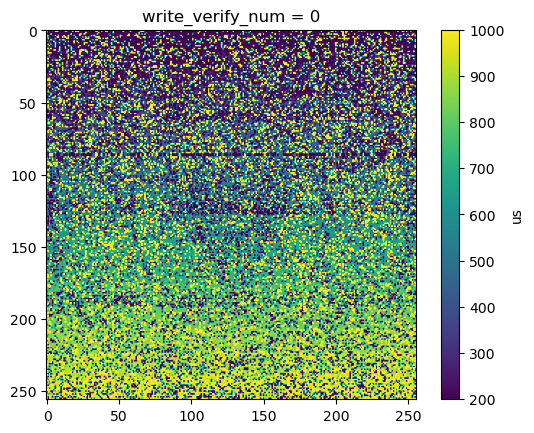

需要写14901个点
需要写24028个点
第1次操作
需要读38929个点
需要读38929个点


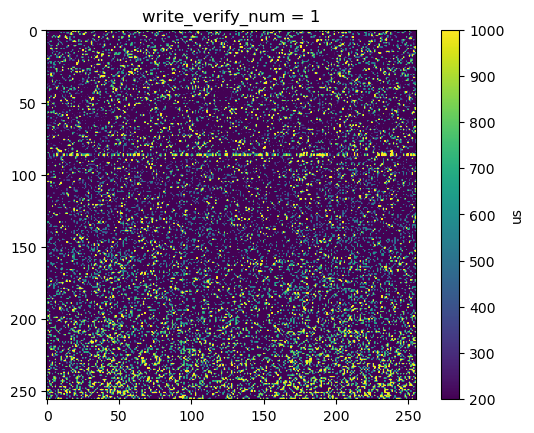

需要写7069个点
需要写28090个点
第2次操作
需要读35159个点


KeyboardInterrupt: 

In [ ]:
need_read = np.ones((256,256),dtype=bool)
voltage_base = np.zeros((256,256))
voltage = np.zeros((256,256))
for i in range(20):
    print(f"第{i}次操作")
    voltage_base[need_read] = chip.read_point2(crossbar=need_read, read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)[need_read]
    voltage[need_read] = chip.read_point2(crossbar=need_read, read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)[need_read]
    cond_sub_base = chip.voltage_to_cond(voltage-voltage_base)

    cmap = plt.cm.viridis
    norm = Normalize(vmin=200, vmax=1000)
    im = plt.imshow(cond_sub_base, cmap=cmap,norm=norm)
    cbar = plt.colorbar(im)
    cbar.set_label("us")
    plt.title(f"write_verify_num = {i}")
    plt.show()


    condition_reset = (cond_sub_base > img_cond_upper) & need_read
    condition_set = (cond_sub_base < img_cond_lower) & need_read
    need_read = condition_reset | condition_set

    # reset操作
    chip.write_point2(crossbar=condition_reset,write_voltage=2+0.1*int((i+1)/2),tg=5,pulse_width=1000e-6,set_device=False)
    # set操作
    chip.write_point2(crossbar=condition_set,write_voltage=3,tg=tg_v,pulse_width=1e-3,set_device=True)

In [ ]:
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1200)
im = plt.imshow(cond_sub_base, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.title(f"write_verify_num = {i}")
plt.show()

In [ ]:
cond_start = chip.voltage_to_cond(voltage2-voltage_base2)

condition_set = (cond_start < 800) & (img > 0.5)
is_set = True
chip.write_point2(crossbar=condition_set,write_voltage=3,tg=2.5,pulse_width=1000e-6,set_device=is_set)

# 5. set之后再读一次看看效果

In [ ]:
# 这里用逐点读+减去0v读的base
voltage_base3 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
voltage3 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)

In [ ]:
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=400)
im = plt.imshow(chip.voltage_to_cond(voltage3-voltage_base3), cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

# 6. 可以根据图片一次完成reset和set操作, 进行写图片

In [ ]:
cond_start = chip.voltage_to_cond(voltage1-voltage_base1)
# 需要写0的地方, 电导>200us, 需要reset
condition_reset = (cond_start > 200) & (img < 0.5)
chip.write_point2(crossbar=condition_reset,write_voltage=2,tg=5,pulse_width=1000e-6,set_device=False)
# 需要写1的地方, 电导<800us, 需要set
condition_set = (cond_start < 800) & (img > 0.5)
chip.write_point2(crossbar=condition_set,write_voltage=3,tg=2.5,pulse_width=1000e-6,set_device=True)

In [ ]:
# 这里用逐点读+减去0v读的base
voltage_base4 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
voltage4 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(chip.voltage_to_cond(voltage4-voltage_base4), cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()